# Imports

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict
from itertools import product
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from main import run_single_tournament

# Resultados

## Gráficos de barra

In [2]:
def plot_final_scores_by_mode_and_rounds(modes, round_grid):
    """
    Gera e salva gráficos de barras com a pontuação final de cada agente, para cada modo.
    """
    order_per_mode = {}  # Ordem dos agentes para cada modo
    color_palette = plt.get_cmap('tab10')

    color_idx = 0
    for mode in modes:
        for n_rounds in round_grid:        
            scores, _, _ = run_single_tournament(render=False, mode=mode, rl_params=None, n_full_rounds=n_rounds)
            agents_dict = dict(scores)

            # Definir ordem fixa específica para o modo
            if mode not in order_per_mode:
                order_per_mode[mode] = sorted(agents_dict.keys())

            order = order_per_mode[mode]
            points = [agents_dict.get(agent, 0) for agent in order]

            plt.figure(figsize=(6, 4))
            plt.bar(order, points, color=color_palette(color_idx % 10))
            plt.title(f'Pontuação Final por Agente\nModo: {mode}, Rodadas: {n_rounds}')
            plt.xlabel('Agentes')
            plt.ylabel('Pontuação Final')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            color_idx += 1

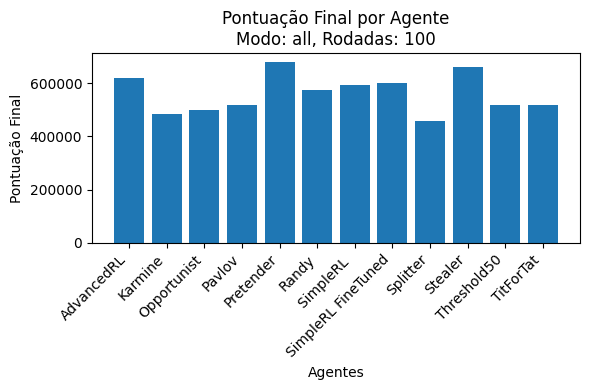

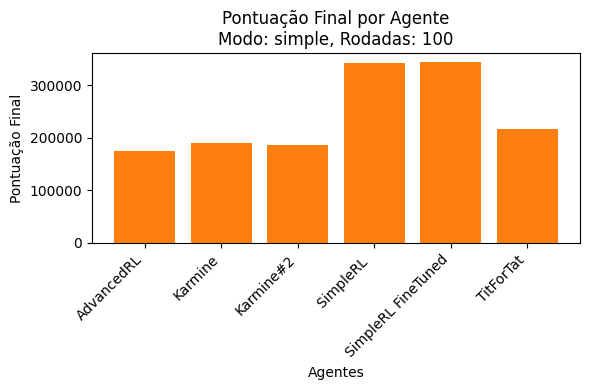

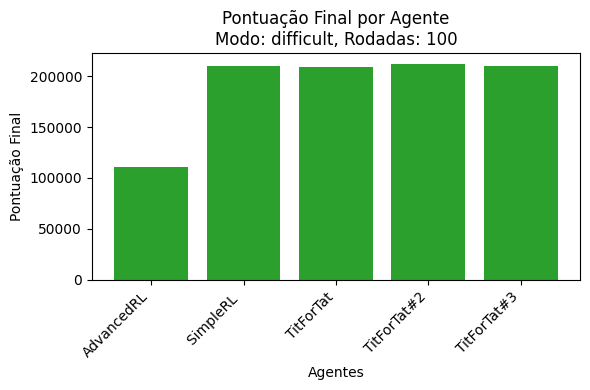

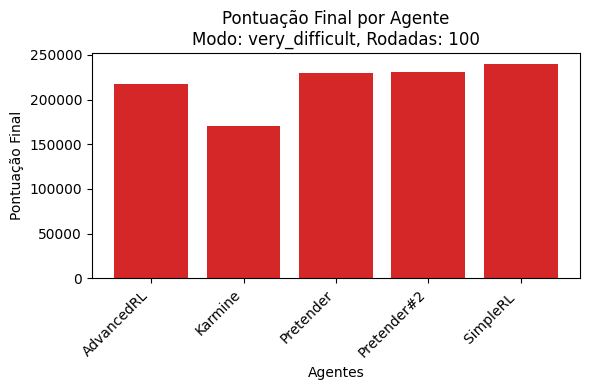

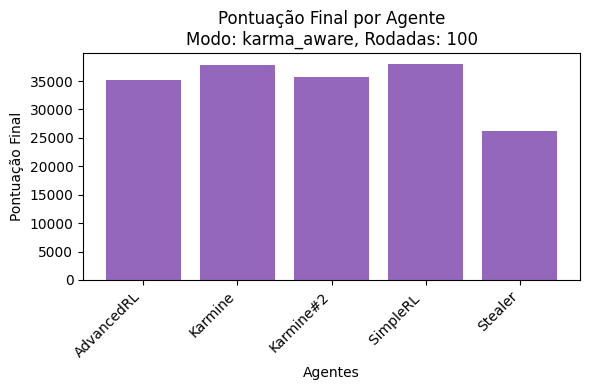

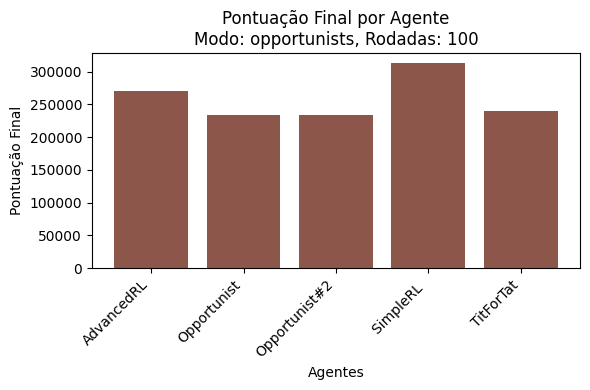

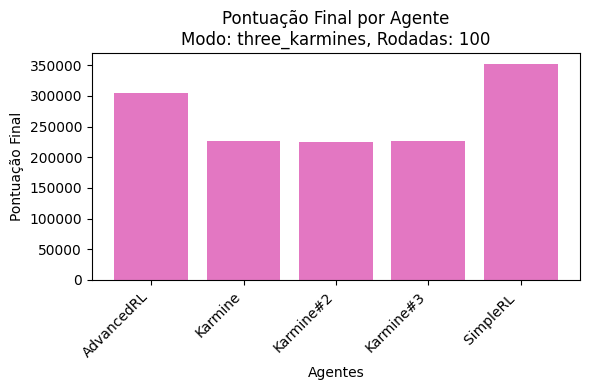

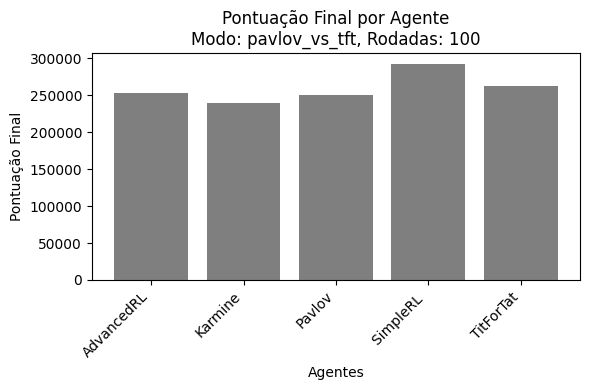

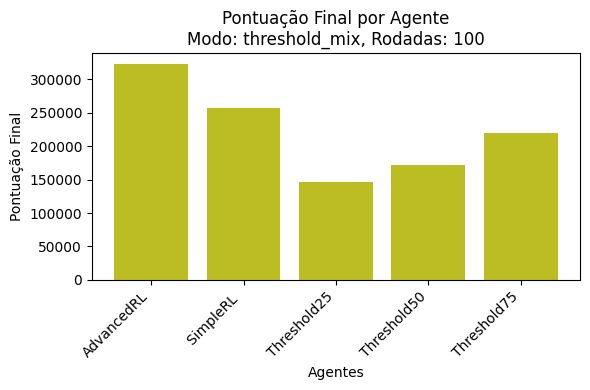

In [3]:
modes = [
    'all',
    'simple',
    'difficult',
    'very_difficult',
    'karma_aware',
    'opportunists',
    'three_karmines',
    'pavlov_vs_tft',
    'threshold_mix'
]
round_grid = [
    # 10, 
    # 50, 
    100,
]
plot_final_scores_by_mode_and_rounds(modes, round_grid)

## Curvas de aprendizado

In [31]:
def plot_cumulative_learning_curves(modes, rl_params=None):
    plt.figure(figsize=(8, 4))
    for mode in modes:
        _, rewards, _ = run_single_tournament(render=False, mode=mode, rl_params=rl_params)
        cumulative = np.cumsum(rewards)
        plt.plot(range(1, len(cumulative) + 1), cumulative, label=mode)
    
    plt.xlabel('Rodada')
    plt.ylabel('Recompensa acumulada')
    plt.title('Curvas de Aprendizado por Modo')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_avarage_learning_curves(modes, rl_params=None):    
    plt.figure(figsize=(10, 5))
    for mode in modes:
        _, rewards, _ = run_single_tournament(render=False, mode=mode, rl_params=rl_params)
        rewards = np.array(rewards)
        
        rounds = np.arange(1, len(rewards) + 1)
        mean_rewards = rewards.cumsum() / rounds
        plt.plot(rounds, mean_rewards, label=mode)

    plt.xlabel('Rodada')
    plt.ylabel('Recompensa média por rodada')
    plt.title('Curvas de Aprendizado (recompensa média) por Modo')
    plt.legend()
    plt.tight_layout()
    plt.show()

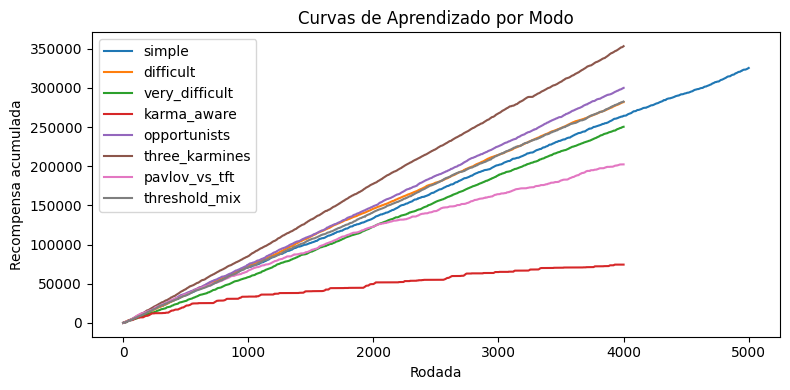

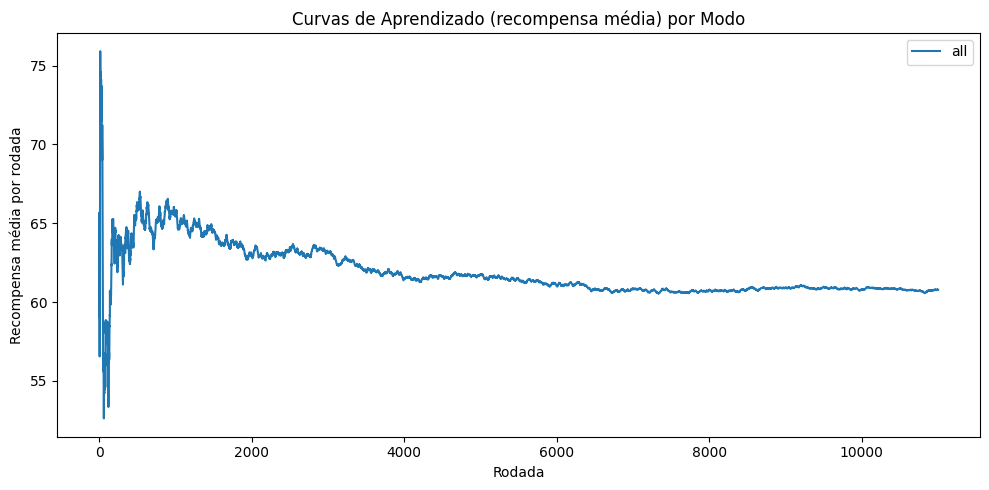

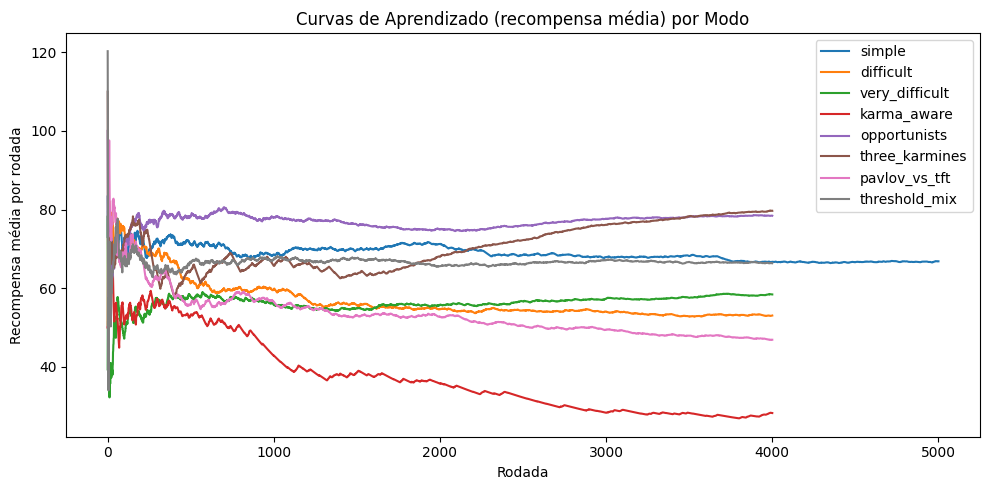

In [32]:

from sympy import plot

modes = [
    # 'all',
    'simple',
    'difficult',
    'very_difficult',
    'karma_aware',
    'opportunists',
    'three_karmines',
    'pavlov_vs_tft',
    'threshold_mix'
]

just_all = [
    'all'
]
plot_cumulative_learning_curves(modes)
plot_avarage_learning_curves(just_all)
plot_avarage_learning_curves(modes)

## GridSearch

In [22]:
def grid_search(mode: str, param_grid: dict, repetitions: int = 3):
    results = []

    # para cada combinação de hiper‑parâmetros
    for alpha, gamma, epsilon in product(param_grid['alpha'], param_grid['gamma'], param_grid['epsilon']):
        scores_acc = []
        
        for _ in range(repetitions):            
            scores, _, _ = run_single_tournament(
                render=False,
                mode=mode,
                rl_params=(alpha, gamma, epsilon)
            )
            
            rl_score = next(score for name, score in scores if name.startswith('SimpleRL'))
            scores_acc.append(rl_score)
        
        mean_score = sum(scores_acc) / repetitions
        results.append({
            'alpha':      alpha,
            'gamma':      gamma,
            'epsilon':    epsilon,
            'mean_score': mean_score
        })
    
    return results

In [23]:
mode = 'simple'
grid = {
    'alpha':   [0.1, 0.3, 0.5, 0.7, 0.9],
    'gamma':   [0.7, 0.9, 0.99],
    'epsilon': [0.01, 0.05, 0.1],
}
repetitions = 5

results = grid_search(
    mode=mode,
    param_grid=grid,
    repetitions=repetitions
)

In [24]:
df = pd.DataFrame(results)
df_top10 = df.nlargest(10, 'mean_score').reset_index(drop=True)

print("\nTop 10 combinações de hiperparâmetros (pelo score médio):\n")
print(
    df_top10.to_string(
        index=False,
        float_format="  %.2f".__mod__  # formata floats com 2 casas
    )
)


Top 10 combinações de hiperparâmetros (pelo score médio):

 alpha  gamma  epsilon  mean_score
  0.70   0.90     0.01   314174.38
  0.50   0.99     0.10   313822.77
  0.70   0.99     0.05   313380.82
  0.90   0.99     0.01   313195.03
  0.30   0.90     0.05   312022.31
  0.30   0.99     0.05   311114.37
  0.70   0.99     0.01   308928.66
  0.90   0.90     0.10   304380.53
  0.70   0.99     0.10   302110.48
  0.10   0.90     0.10   301555.14


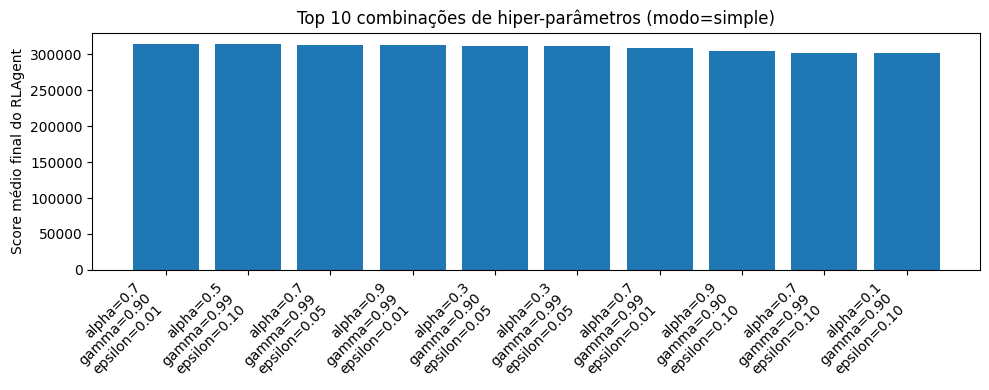

In [25]:
plt.figure(figsize=(10,4))
labels = [
    f"alpha={r.alpha:.1f}\ngamma={r.gamma:.2f}\nepsilon={r.epsilon:.2f}"
    for _, r in df_top10.iterrows()
]
plt.bar(labels, df_top10['mean_score'])
plt.xticks(rotation=45, ha='right')
plt.title(f"Top 10 combinações de hiper-parâmetros (modo={mode})")
plt.ylabel("Score médio final do RLAgent")
plt.tight_layout()
plt.show()

## Heatmap da q_table

In [5]:
def extract_q_table_dataframe(rl_agent):
    """
    Extrai a Q-table do agente RL como um DataFrame estruturado.
    
    Retorna um DataFrame com colunas:
    - Your_Karma
    - Opponent_Karma_Sign
    - Q_Split: valor Q da ação 'split'
    - Q_Steal: valor Q da ação 'steal'
    """
    q_data = []
    for state, q_values in rl_agent.Q.items():
        your_karma = state[0]
        opponent_karma_sign = state[1]
        q_split, q_steal = q_values
        q_data.append((your_karma, opponent_karma_sign, q_split, q_steal))
    
    return pd.DataFrame(q_data, columns=["Your_Karma", "Opponent_Karma_Sign", "Q_Split", "Q_Steal"])

In [18]:

def make_custom_cmap(colors, name="custom_cmap"):
    """
    Cria um colormap linear customizado a partir de uma lista de cores.
    Exemplo de uso: make_custom_cmap(["#0000ff", "#ffffff", "#ff0000"])
    """
    return LinearSegmentedColormap.from_list(name, colors)

# Exemplos de gradientes customizáveis:
COOLWARM_CMAP = make_custom_cmap(["#4575b4", "#ffffff", "#d73027"], name="coolwarm_custom")
BLUES_CMAP = make_custom_cmap(["#d73027", "#ffffff", "#4575b4"], name="blues_custom")

def plot_heat_maps_side_by_side(modes, rl_params=None, cmap_steal=COOLWARM_CMAP, cmap_split=BLUES_CMAP):
    """
    Para cada modo, plota lado a lado os heatmaps dos Q-values para as ações 'Steal' e 'Split'.
    As cores dos heatmaps podem ser personalizadas via cmap_steal e cmap_split.
    """
    for mode in modes:
        _, _, rl_agent = run_single_tournament(render=False, mode=mode, rl_params=rl_params)
        q_df = extract_q_table_dataframe(rl_agent)

        # Verificar se há dados suficientes
        if q_df.empty:
            print(f"Nenhum dado de Q-table encontrado para o modo: {mode}")
            continue

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Steal
        pivot_steal = q_df.pivot_table(
            index="Your_Karma", 
            columns="Opponent_Karma_Sign", 
            values="Q_Steal",
            aggfunc="mean",
            fill_value=0  # Preenche valores ausentes com 0
        )
        
        # Garantir que não há valores NaN
        pivot_steal = pivot_steal.fillna(0)
        
        sns.heatmap(
            pivot_steal, 
            annot=True, 
            fmt=".3f",  # Aumentar precisão para valores pequenos
            cmap=cmap_steal, 
            center=0, 
            ax=axes[0],
            annot_kws={"size": 10},  # Ajustar tamanho da fonte
            linewidths=0.5,  # Adicionar linhas para separar células
            cbar_kws={"shrink": 0.8}
        )
        axes[0].set_title(f"Heatmap Q-value: Steal — modo: {mode}")
        axes[0].set_ylabel("Your_Karma")
        axes[0].set_xlabel("Opponent_Karma_Sign")

        # Split
        pivot_split = q_df.pivot_table(
            index="Your_Karma", 
            columns="Opponent_Karma_Sign", 
            values="Q_Split",
            aggfunc="mean",
            fill_value=0  # Preenche valores ausentes com 0
        )
        
        # Garantir que não há valores NaN
        pivot_split = pivot_split.fillna(0)
        
        sns.heatmap(
            pivot_split, 
            annot=True, 
            fmt=".3f",  # Aumentar precisão para valores pequenos
            cmap=cmap_split, 
            center=0, 
            ax=axes[1],
            annot_kws={"size": 10},  # Ajustar tamanho da fonte
            linewidths=0.5,  # Adicionar linhas para separar células
            cbar_kws={"shrink": 0.8}
        )
        axes[1].set_title(f"Heatmap Q-value: Split — modo: {mode}")
        axes[1].set_ylabel("Your_Karma")
        axes[1].set_xlabel("Opponent_Karma_Sign")

        plt.tight_layout()
        plt.show()

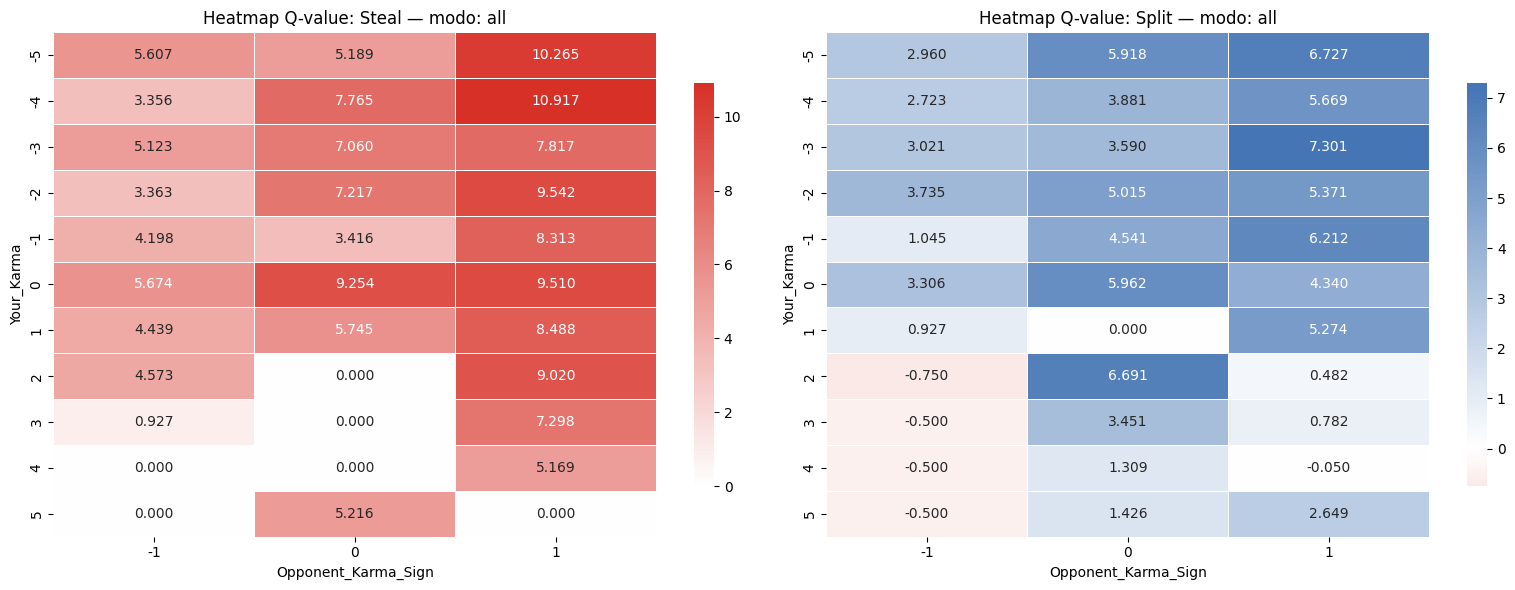

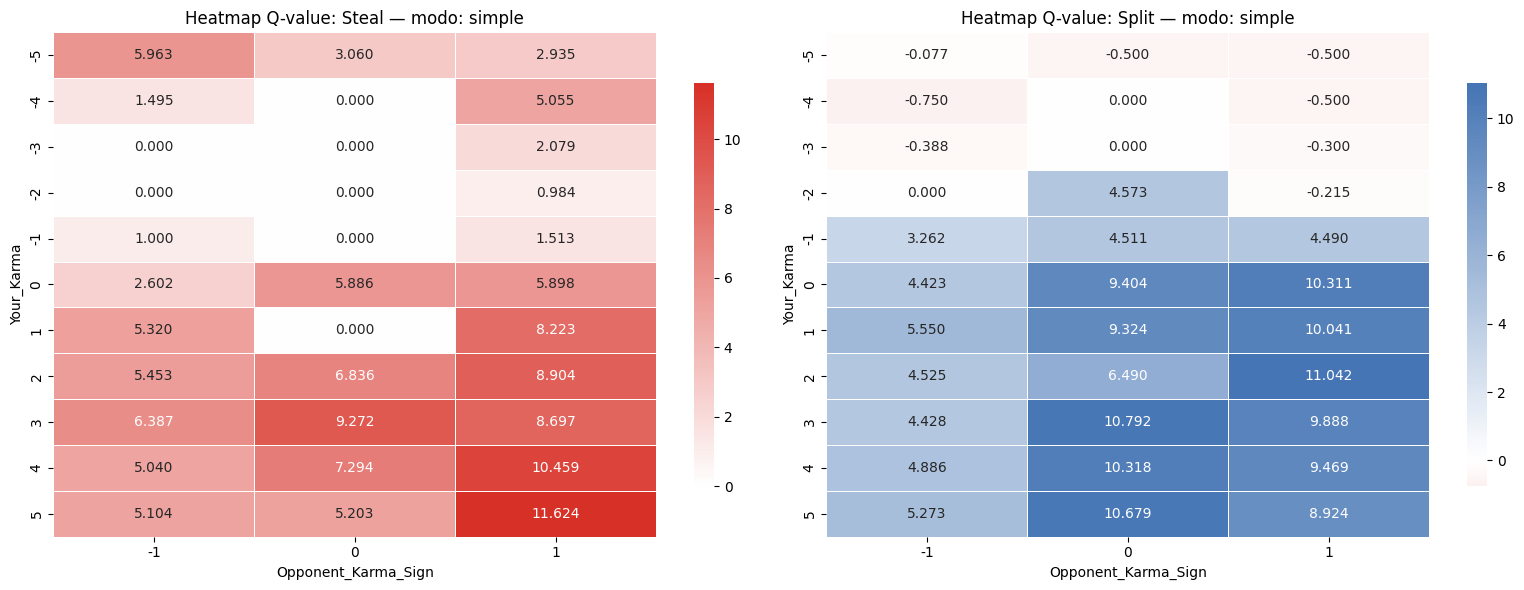

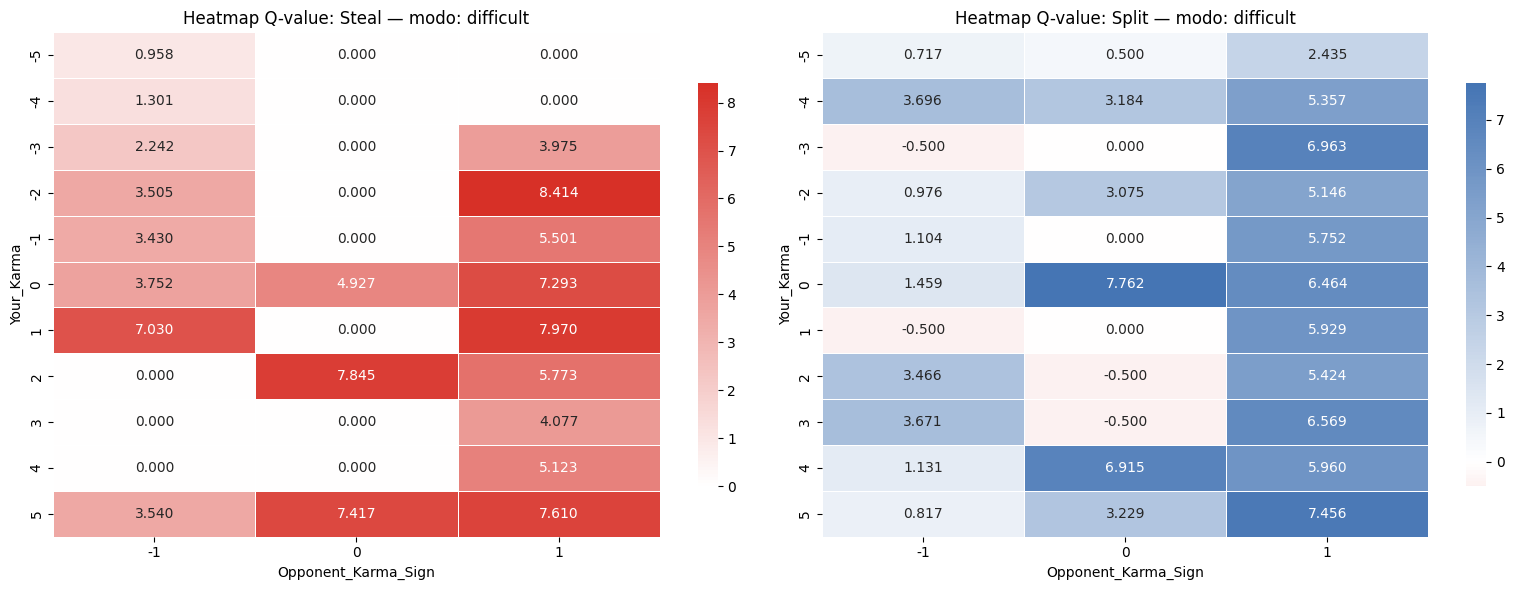

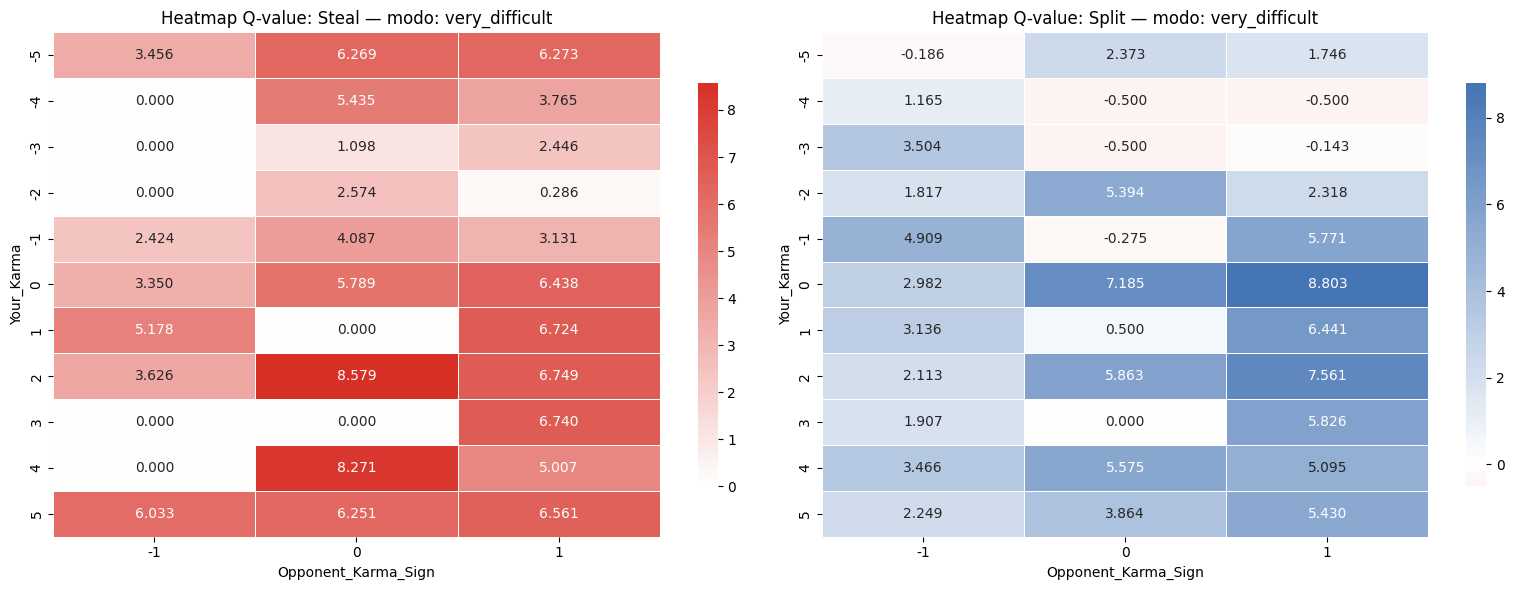

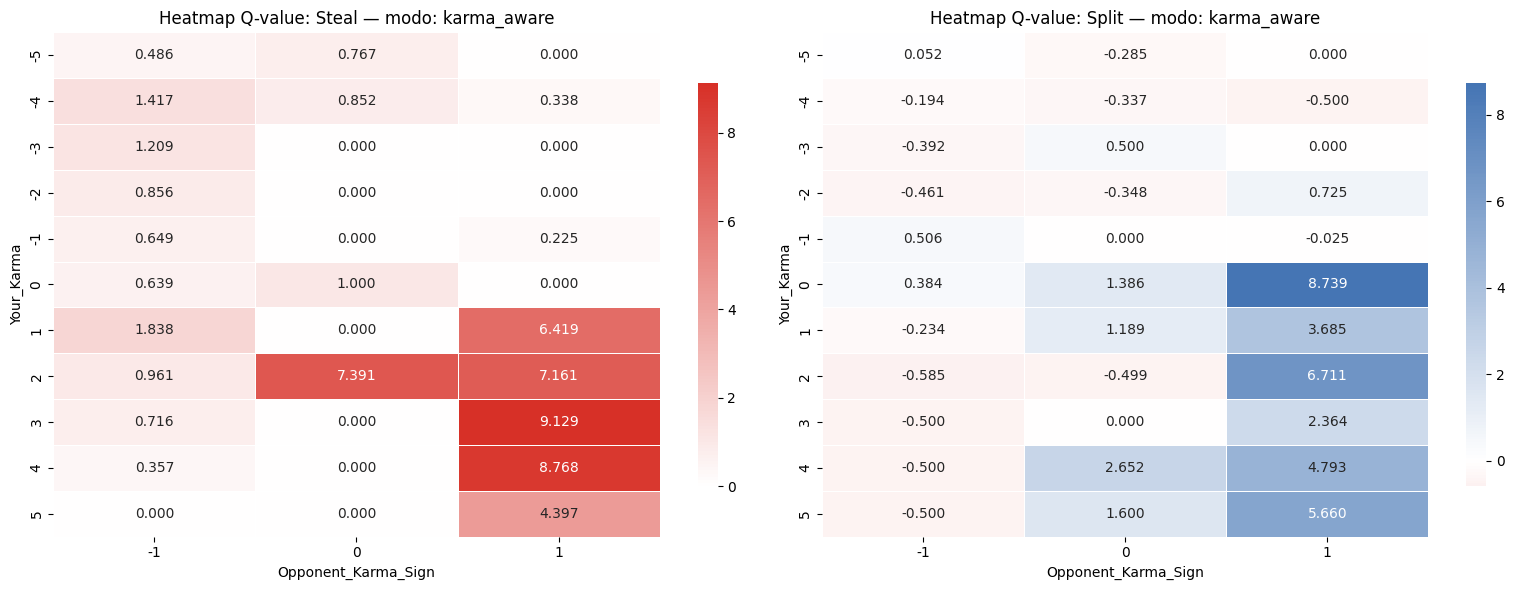

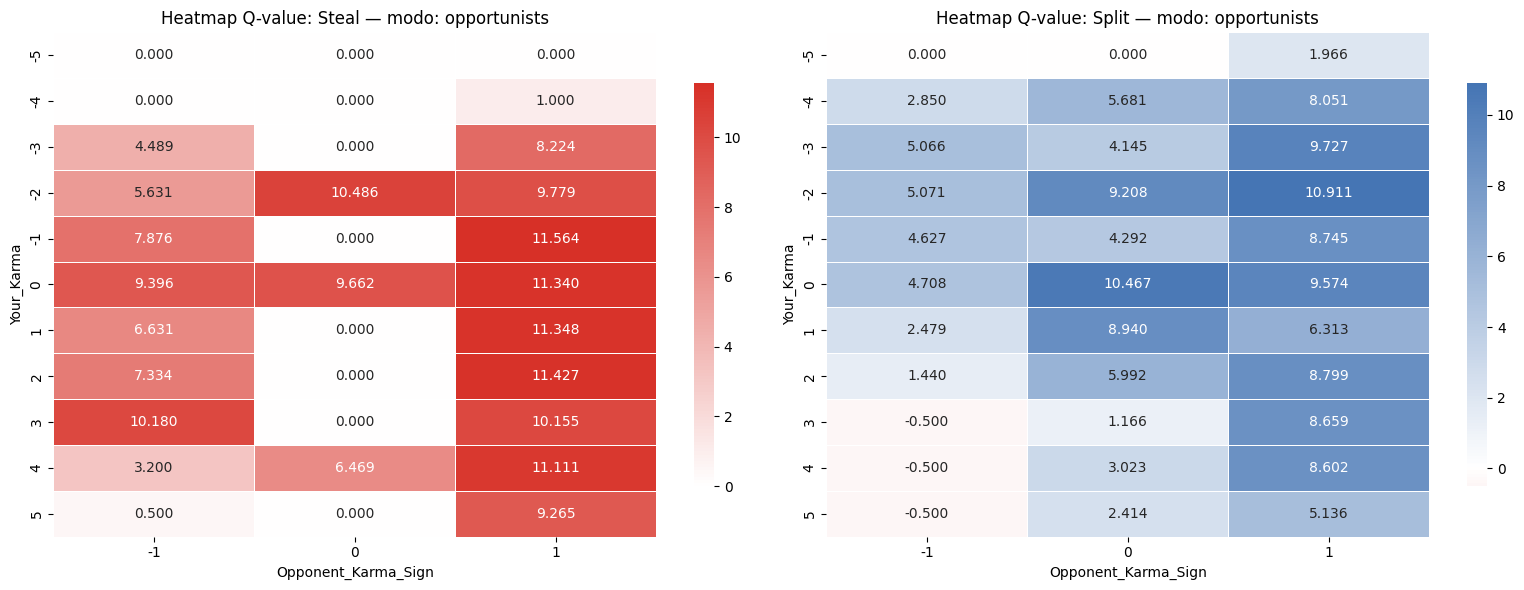

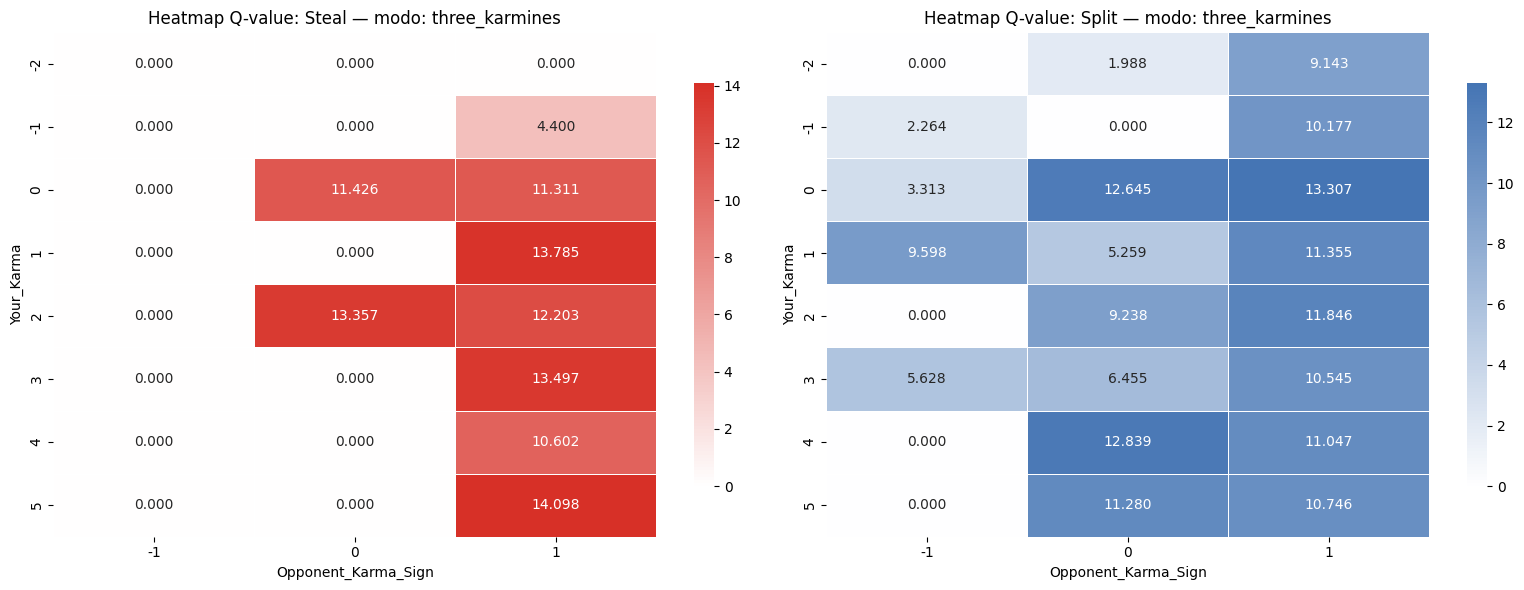

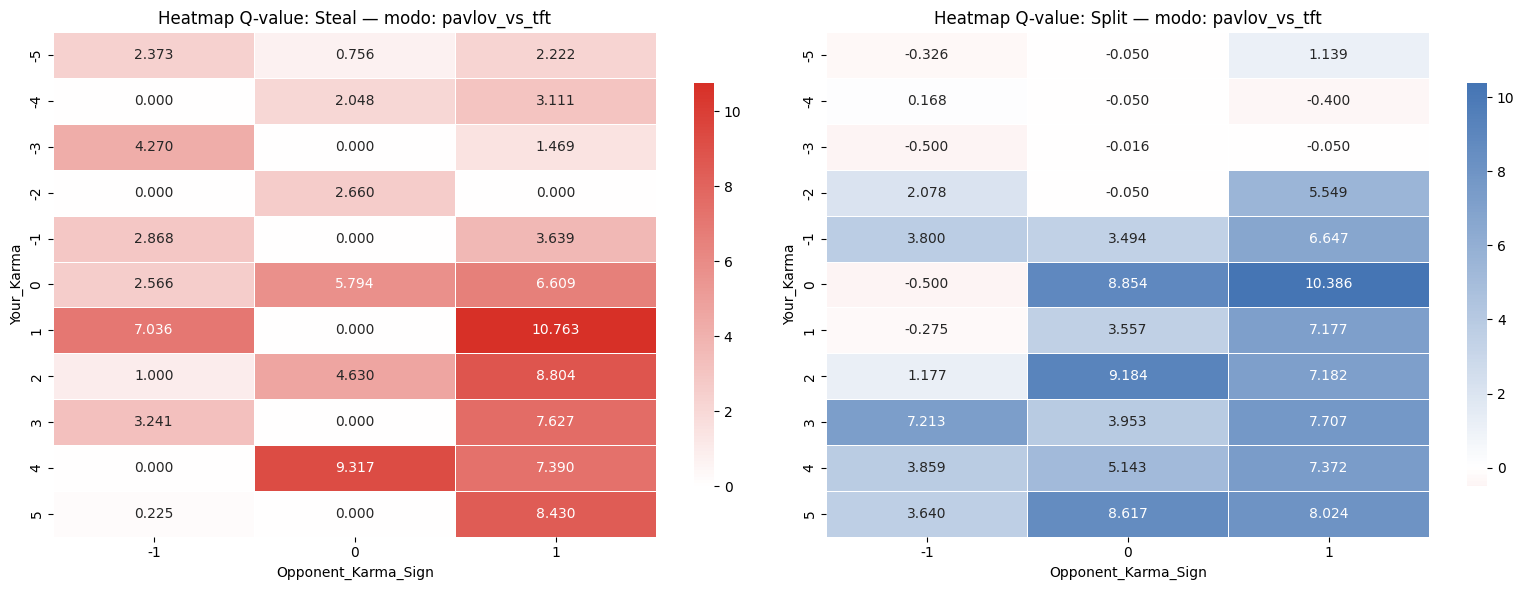

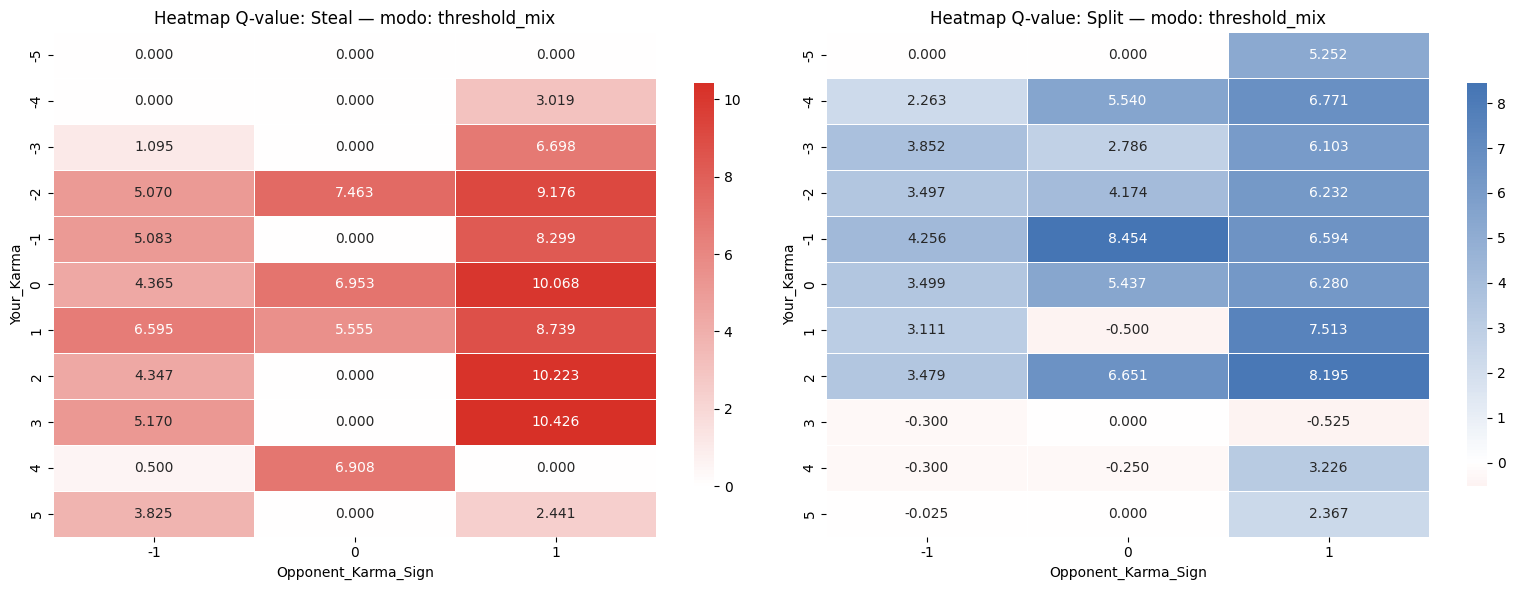

In [19]:
modes = [
    'all',
    'simple',
    'difficult',
    'very_difficult',
    'karma_aware',
    'opportunists',
    'three_karmines',
    'pavlov_vs_tft',
    'threshold_mix'
]

plot_heat_maps_side_by_side(modes, rl_params=(0.5, 0.9, 0.1))  # Exemplo com parâmetros específicos